In [187]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [188]:
!pip install scanpy
!pip install matplotlib==3.1.3
!pip install -U tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.5.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.1 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [189]:
import numpy as np 
import pandas as pd 
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
import scipy
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [190]:
Pancreas_adata = sc.read_text("/content/drive/My Drive/ML for genomics project group /Data/Pancreas Data/Processed/Pancreas_LogX_CellCycleRegressedOut.txt", delimiter = '\t', first_column_names=None)
sc.pp.scale(Pancreas_adata)
Pancreas_adata

AnnData object with n_obs × n_vars = 2209 × 26179
    var: 'mean', 'std'

In [191]:
PancreasMetadata = pd.read_csv("/content/drive/My Drive/ML for genomics project group /Data/Pancreas Data/Processed/PancreasMetadata.csv")
Pancreas_adata.obs['Cell Type'] = PancreasMetadata['Cell type'].values
Pancreas_adata.obs['Cell Type'].unique()

array(['γ', 'α', 'β', 'acinar', 'ε', 'unclassified exocrine', 'ductal',
       'δ', 'unclassified endocrine', 'endothelial', 'co-expression',
       'PSC', 'mast', 'MHC'], dtype=object)

In [192]:
PancreasCellID = []
for item in PancreasMetadata['Cell ID'].values:
  PancreasCellID.append(item)
Pancreas_adata.obs_names = PancreasCellID
Pancreas_adata.obs_names

Index(['HP1502401_H13', 'HP1502401_J14', 'HP1502401_B14', 'HP1502401_A14',
       'HP1502401_C14', 'HP1502401_G14', 'HP1502401_E14', 'HP1502401_L14',
       'HP1502401_M14', 'HP1502401_K14',
       ...
       'HP1526901T2D_M7', 'HP1526901T2D_N16', 'HP1526901T2D_C8',
       'HP1526901T2D_H2', 'HP1526901T2D_I16', 'HP1526901T2D_F7',
       'HP1525301T2D_K3', 'HP1525301T2D_J10', 'HP1526901T2D_N8',
       'HP1526901T2D_A8'],
      dtype='object', length=2209)

In [193]:
PancreasGenes = pd.read_csv("/content/drive/My Drive/ML for genomics project group /Data/Pancreas Data/Processed/Pancreas_Genelist.txt",header=None)
PancreasGenelist = []
for item in PancreasGenes.values.tolist():
  PancreasGenelist.append(item[0])
Pancreas_adata.var_names = PancreasGenelist
Pancreas_adata.var_names

Index(['SGIP1', 'AZIN2', 'CLIC4', 'AGBL4', 'NECAP2', 'SLC45A1', 'TGFBR3',
       'DBT', 'RFWD2', 'C1orf21',
       ...
       'KIR3DS1', 'KIR2DL5B', 'KIR2DS2', 'KIR2DS1', 'KIR2DL2', 'KIR2DL4',
       'KIR2DS3', 'KIR2DS2', 'BIVM-ERCC5', 'ERCC_30000:mix1_7500:mix2'],
      dtype='object', length=26179)

In [194]:
MarkerGeneList = pd.read_csv("/content/drive/My Drive/ML for genomics project group /Data/PanglaoDB_Markers.tsv",sep='\t')

In [195]:
PancreasMarkers = MarkerGeneList.iloc[np.asarray(np.where((MarkerGeneList['organ'] == 'Pancreas') & (MarkerGeneList['species'] != 'Mm')))[0,:],:]
PancreasMarkers

,species,official gene symbol,cell type,nicknames,ubiquitousness index,product description,gene type,canonical marker,germ layer,organ,sensitivity_human,sensitivity_mouse,specificity_human,specificity_mouse
0,Mm Hs,CTRB1,Acinar cells,CTRB,0.017,chymotrypsinogen B1,protein-coding gene,1.0,Endoderm,Pancreas,1.000000,0.957143,0.000629,0.015920
1,Mm Hs,KLK1,Acinar cells,Klk6,0.013,kallikrein 1,protein-coding gene,1.0,Endoderm,Pancreas,0.833333,0.314286,0.005031,0.012826
2,Mm Hs,RBPJL,Acinar cells,RBP-L|SUHL|RBPSUHL,0.001,recombination signal binding protein for immun...,protein-coding gene,1.0,Endoderm,Pancreas,0.000000,0.000000,0.000000,0.000000
3,Mm Hs,PTF1A,Acinar cells,PTF1-p48|bHLHa29,0.001,pancreas associated transcription factor 1a,protein-coding gene,1.0,Endoderm,Pancreas,0.000000,0.157143,0.000629,0.000773
5,Mm Hs,CELA3A,Acinar cells,ELA3|ELA3A,0.001,chymotrypsin like elastase family member 3A,protein-coding gene,1.0,Endoderm,Pancreas,0.833333,0.128571,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6374,Mm Hs,LRRTM1,Peri-islet Schwann cells,FLJ32082,0.005,leucine rich repeat transmembrane neuronal 1,protein-coding gene,NaN,Endoderm,Pancreas,0.000000,0.300000,0.001567,0.006292
6375,Mm Hs,SEMA3B,Peri-islet Schwann cells,SemA|semaV|LUCA-1|sema5|SEMAA,0.009,semaphorin 3B,protein-coding gene,NaN,Endoderm,Pancreas,1.000000,0.000000,0.017549,0.000000
6376,Mm Hs,NGFR,Peri-islet Schwann cells,TNFRSF16|CD271|p75NTR,0.007,nerve growth factor receptor,protein-coding gene,NaN,Endoderm,Pancreas,1.000000,1.000000,0.001880,0.006806
6377,Mm Hs,PNLIPRP1,Peri-islet Schwann cells,PLRP1,0.008,pancreatic lipase related protein 1,protein-coding gene,NaN,Endoderm,Pancreas,0.000000,0.200000,0.001880,0.009310


In [196]:
pd.unique(MarkerGeneList['cell type'])

array(['Acinar cells', 'Adipocyte progenitor cells', 'Adipocytes',
       'Adrenergic neurons', 'Airway epithelial cells',
       'Airway goblet cells', 'Airway smooth muscle cells', 'Alpha cells',
       'Alveolar macrophages', 'Anterior pituitary gland cells',
       'Astrocytes', 'B cells', 'B cells memory', 'B cells naive',
       'Basal cells', 'Basophils', 'Bergmann glia', 'Beta cells',
       'Cajal-Retzius cells', 'Cardiac stem and precursor cells',
       'Cardiomyocytes', 'Cholangiocytes', 'Cholinergic neurons',
       'Chondrocytes', 'Choroid plexus cells', 'Chromaffin cells',
       'Ciliated cells', 'Clara cells', 'Crypt cells', 'Decidual cells',
       'Delta cells', 'Dendritic cells', 'Distal tubule cells',
       'Dopaminergic neurons', 'Ductal cells', 'Embryonic stem cells',
       'Endothelial cells', 'Endothelial cells (aorta)',
       'Endothelial cells (blood brain barrier)', 'Enteric glia cells',
       'Enteric neurons', 'Enterochromaffin cells', 'Enterocytes',
 

In [197]:
pd.unique(PancreasMarkers['cell type'])

array(['Acinar cells', 'Alpha cells', 'Beta cells', 'Delta cells',
       'Ductal cells', 'Epsilon cells', 'Gamma (PP) cells',
       'Pancreatic progenitor cells', 'Pancreatic stellate cells',
       'Peri-islet Schwann cells'], dtype=object)

In [198]:
Pancreas_adata.obs['Cell Type'].unique()

array(['γ', 'α', 'β', 'acinar', 'ε', 'unclassified exocrine', 'ductal',
       'δ', 'unclassified endocrine', 'endothelial', 'co-expression',
       'PSC', 'mast', 'MHC'], dtype=object)

In [199]:
# Manually get rid of unwanted cell types: Pancreatic progenitor cells and Peri-islet Schwann cells 
PancreasMarkers = PancreasMarkers.iloc[np.asarray(np.where(PancreasMarkers['cell type'] != 'Pancreatic progenitor cells'))[0,:],:]
PancreasMarkers = PancreasMarkers.iloc[np.asarray(np.where(PancreasMarkers['cell type'] != 'Peri-islet Schwann cells'))[0,:],:]

# Manually add cell types: endocrine, endothelial, mast, MHC (dendritic, macrophages, B cells)
# unclassified exocrine cells are also acinar cells; co-expression is not a defined cell type
PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'Enteroendocrine cells'))[0,:],:])
PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'Endothelial cells'))[0,:],:])
PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'Mast cells'))[0,:],:])
PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'Dendritic cells'))[0,:],:])
PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'Macrophages'))[0,:],:])
PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'B cells'))[0,:],:])

pd.unique(PancreasMarkers['cell type'])

array(['Acinar cells', 'Alpha cells', 'Beta cells', 'Delta cells',
       'Ductal cells', 'Epsilon cells', 'Gamma (PP) cells',
       'Pancreatic stellate cells', 'Enteroendocrine cells',
       'Endothelial cells', 'Mast cells', 'Dendritic cells',
       'Macrophages', 'B cells'], dtype=object)

In [200]:
PancreasMarkers['cell type'] = PancreasMarkers['cell type'].replace(['B cells', 'Macrophages', 'Dendritic cells'],
                                                                    'MHC')
pd.unique(PancreasMarkers['cell type'])

array(['Acinar cells', 'Alpha cells', 'Beta cells', 'Delta cells',
       'Ductal cells', 'Epsilon cells', 'Gamma (PP) cells',
       'Pancreatic stellate cells', 'Enteroendocrine cells',
       'Endothelial cells', 'Mast cells', 'MHC'], dtype=object)

In [201]:
PanglaoDB_Pancreas = PancreasMarkers['official gene symbol']
PanglaoDB_Pancreas = list(set(PanglaoDB_Pancreas) & set(Pancreas_adata.var_names)) # overlap between dataset gene list and the PanglaoDB set 
len(PanglaoDB_Pancreas)

874

In [202]:
# Pancreas_adata.write(filename="/content/drive/My Drive/ML4FG 2022/Data/Pancreas Data/Processed/Pancreas_CellCycleRegressedOut_AnnData.h5ad")

In [203]:
# Create a variable list for input genes / features 

Panglao_Input = []

for i in range(Pancreas_adata.shape[1]):
  if Pancreas_adata.var_names[i] in set(PanglaoDB_Pancreas):
    Panglao_Input.append(True)
  else: 
    Panglao_Input.append(False)

Pancreas_adata.var['input_features'] = Panglao_Input
Pancreas_adata.var['input_features']

SGIP1                        False
AZIN2                        False
CLIC4                         True
AGBL4                        False
NECAP2                       False
                             ...  
KIR2DL4                      False
KIR2DS3                      False
KIR2DS2                      False
BIVM-ERCC5                   False
ERCC_30000:mix1_7500:mix2    False
Name: input_features, Length: 26179, dtype: bool

In [204]:
# Create anndata input for the model by filtering Pancreas_adata

Pancreas_input = Pancreas_adata[:,Pancreas_adata.var['input_features']]
Pancreas_input

View of AnnData object with n_obs × n_vars = 2209 × 882
    obs: 'Cell Type'
    var: 'mean', 'std', 'input_features'

In [205]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [206]:
class VariationalAutoencoder(Model):
    def __init__(self, num_cell_types, num_genes, reg_penalties):
        super(VariationalAutoencoder, self).__init__()  
        self.reg_penalties = reg_penalties
        self.mean_encoder = tf.keras.Sequential([
         layers.Dense(num_cell_types, activation='linear', 
                      kernel_regularizer=self.encoder_marker_gene_regularizer),
        ])
        self.var_encoder = tf.keras.Sequential([
         layers.Dense(num_cell_types, activation='linear', 
                      kernel_regularizer=self.encoder_marker_gene_regularizer),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(num_genes, activation='linear', 
                      kernel_regularizer=self.decoder_marker_gene_regularizer)
        ])

    def reparameterization(self, mean, var):
        epsilon = tf.random.normal(shape = [mean.shape[1]])             
        z = mean + (var*epsilon)                       
        return z
        
    def call(self, x):
        mean = self.mean_encoder(x)
        log_var = self.var_encoder(x)
        z = self.reparameterization(mean, tf.exp(0.5 * log_var))
        p = tf.keras.activations.softmax(z)
        decoded = self.decoder(p)
        return decoded

    def embed(self, x):
        mean = self.mean_encoder(x)
        log_var = self.var_encoder(x)
        var = tf.exp(0.5 * log_var)
        return tf.keras.activations.softmax(mean), mean, var

    def encoder_marker_gene_regularizer(self, w):
        return tf.reduce_sum(self.reg_penalties * tf.square(w))

    def decoder_marker_gene_regularizer(self, w):
        return tf.reduce_sum(self.reg_penalties.T * tf.square(w))

In [207]:
class Autoencoder(Model):
    def __init__(self, num_cell_types, num_genes, reg_penalties):
        super(Autoencoder, self).__init__()  
        self.reg_penalties = reg_penalties
        self.encoder = tf.keras.Sequential([
         layers.Dense(num_cell_types, activation='softmax', 
                      kernel_regularizer=self.encoder_marker_gene_regularizer),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(num_genes, activation='linear', 
                      kernel_regularizer=self.decoder_marker_gene_regularizer)
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def embed(self, x):
      encoded = self.encoder(x)
      return encoded

    def encoder_marker_gene_regularizer(self, w):
      return tf.reduce_sum(self.reg_penalties * tf.square(w))

    def decoder_marker_gene_regularizer(self, w):
      return tf.reduce_sum(self.reg_penalties.T * tf.square(w))

In [208]:
# Creating regularization mask 

RegLevel = 0

marker_genes = Pancreas_input.var_names
cell_types = pd.unique(PancreasMarkers['cell type'])

marker_gene_cell_type_reg_penalties = np.ones((len(marker_genes), len(cell_types))) * RegLevel
marker_gene_cell_type_reg_penalties.shape

(882, 12)

In [209]:
NumPancreasCellTypes = len(PancreasMarkers['cell type'].unique())
num_genes = Pancreas_input.shape[1]
autoencoder = VariationalAutoencoder(NumPancreasCellTypes, num_genes, 
                                    marker_gene_cell_type_reg_penalties)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
                    loss=losses.MeanSquaredError())
history = autoencoder.fit(Pancreas_input.X, Pancreas_input.X,
                          epochs=25,
                          shuffle=True,
                          validation_data=(Pancreas_input.X, Pancreas_input.X))

Epoch 1/25
70/70 [==============================] - 1s 8ms/step - loss: 281.5766 - val_loss: 277.8832
Epoch 2/25
70/70 [==============================] - 0s 6ms/step - loss: 274.4487 - val_loss: 270.8458
Epoch 3/25
70/70 [==============================] - 0s 6ms/step - loss: 267.4951 - val_loss: 263.9799
Epoch 4/25
70/70 [==============================] - 0s 6ms/step - loss: 260.7103 - val_loss: 257.2796
Epoch 5/25
70/70 [==============================] - 1s 10ms/step - loss: 254.0878 - val_loss: 250.7385
Epoch 6/25
70/70 [==============================] - 1s 11ms/step - loss: 247.6221 - val_loss: 244.3517
Epoch 7/25
70/70 [==============================] - 1s 10ms/step - loss: 241.3082 - val_loss: 238.1144
Epoch 8/25
70/70 [==============================] - 1s 12ms/step - loss: 235.1416 - val_loss: 232.0216
Epoch 9/25
70/70 [==============================] - 1s 14ms/step - loss: 229.1173 - val_loss: 226.0691
Epoch 10/25
70/70 [==============================] - 1s 13ms/step - loss: 223

Text(0.5, 0, 'Epochs')

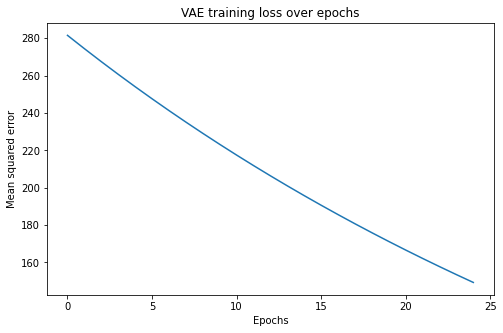

In [210]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.title('VAE training loss over epochs')
plt.ylabel('Mean squared error')
plt.xlabel('Epochs')

In [211]:
def Compute_tTest(mean1,var1,mean2,var2,n):
  tScore = (mean1-mean2) / math.sqrt((var1+var2)/n)
  DegFreedom = ((((var1**2)+(var2**2))/n)**2) / ((((var1**2)+(var2**2))/(n**2))/(n-1))
  return scipy.stats.t.sf(abs(tScore), df=DegFreedom)

In [212]:
latent_embedding, mean, var = autoencoder.embed(Pancreas_input.X) 

cell_type_labels  = []
for item in latent_embedding:
  cell_type_labels.append(str(np.where(item == max(item))[0][0]))

# compute pValue of each assignment and assign 'unknown' labels according p-value threshold
# NumPancreasCells = Pancreas_input.shape[0]
# Pancreas_Assignment_PValues = []
# pVal_Threshold = 10

# for cell in range(NumPancreasCells):
#     MaxIndex = tf.math.argmax(latent_embedding[cell,:]).numpy()
#     pVal = []
#     for LatentNode in range(NumPancreasCellTypes):
#       if LatentNode != MaxIndex:
#         pVal.append(Compute_tTest(mean[cell,MaxIndex],var[cell,MaxIndex],
#                                    mean[cell,LatentNode],var[cell,LatentNode],
#                                    num_genes))
#     Pancreas_Assignment_PValues.append(pVal[np.argmax(pVal)])
#     if pVal[np.argmax(pVal)] > pVal_Threshold:
#       print('Not Confident: ' + cell_type_labels[cell] + ' = ' + str(pVal[np.argmax(pVal)]))
#       cell_type_labels[cell] = 'Unknown'

# Pancreas_Assignment_PValues = np.array(Pancreas_Assignment_PValues).ravel()
# Pancreas_adata.obs['Pancreas pVal'] = Pancreas_Assignment_PValues

Pancreas_adata.obs['VAE Predicted Cell Type'] = cell_type_labels

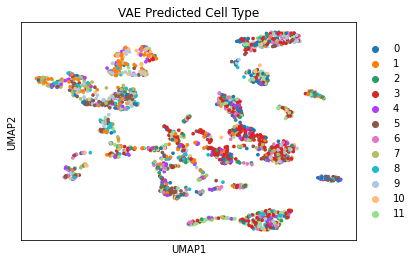

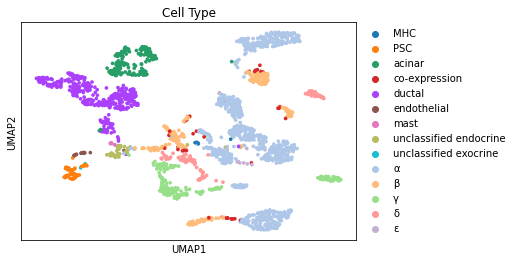

In [213]:
sc.tl.pca(Pancreas_adata, svd_solver='arpack', use_highly_variable=False)
sc.pp.neighbors(Pancreas_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(Pancreas_adata)

sc.pl.umap(Pancreas_adata, color=['VAE Predicted Cell Type'])
sc.pl.umap(Pancreas_adata, color=['Cell Type'])

In [214]:
NumPancreasCellTypes = len(PancreasMarkers['cell type'].unique())
num_genes = Pancreas_input.shape[1]
autoencoder = Autoencoder(NumPancreasCellTypes, num_genes, 
                          marker_gene_cell_type_reg_penalties)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
                    loss=losses.MeanSquaredError())
history = autoencoder.fit(Pancreas_input.X, Pancreas_input.X,
                          epochs=25,
                          shuffle=True,
                          validation_data=(Pancreas_input.X, Pancreas_input.X))

Epoch 1/25
70/70 [==============================] - 1s 8ms/step - loss: 188.1301 - val_loss: 185.6737
Epoch 2/25
70/70 [==============================] - 0s 5ms/step - loss: 183.3896 - val_loss: 180.9937
Epoch 3/25
70/70 [==============================] - 0s 5ms/step - loss: 178.7655 - val_loss: 176.4279
Epoch 4/25
70/70 [==============================] - 0s 5ms/step - loss: 174.2534 - val_loss: 171.9720
Epoch 5/25
70/70 [==============================] - 0s 5ms/step - loss: 169.8493 - val_loss: 167.6220
Epoch 6/25
70/70 [==============================] - 0s 5ms/step - loss: 165.5495 - val_loss: 163.3745
Epoch 7/25
70/70 [==============================] - 0s 5ms/step - loss: 161.3504 - val_loss: 159.2262
Epoch 8/25
70/70 [==============================] - 0s 5ms/step - loss: 157.2490 - val_loss: 155.1739
Epoch 9/25
70/70 [==============================] - 0s 5ms/step - loss: 153.2422 - val_loss: 151.2147
Epoch 10/25
70/70 [==============================] - 0s 5ms/step - loss: 149.3273 

In [215]:
latent_embedding = autoencoder.embed(Pancreas_input.X)

cell_type_labels  = []
for item in latent_embedding:
  cell_type_labels.append(str(np.where(item == max(item))[0][0]))

# compute pValue of each assignment and assign 'unknown' labels according p-value threshold
# NumPancreasCells = Pancreas_input.shape[0]
# Pancreas_Assignment_PValues = []
# pVal_Threshold = 10

# for cell in range(NumPancreasCells):
#     MaxIndex = tf.math.argmax(latent_embedding[cell,:]).numpy()
#     pVal = []
#     for LatentNode in range(NumPancreasCellTypes):
#       if LatentNode != MaxIndex:
#         pVal.append(Compute_tTest(mean[cell,MaxIndex],var[cell,MaxIndex],
#                                    mean[cell,LatentNode],var[cell,LatentNode],
#                                    num_genes))
#     Pancreas_Assignment_PValues.append(pVal[np.argmax(pVal)])
#     if pVal[np.argmax(pVal)] > pVal_Threshold:
#       print('Not Confident: ' + cell_type_labels[cell] + ' = ' + str(pVal[np.argmax(pVal)]))
#       cell_type_labels[cell] = 'Unknown'

# Pancreas_Assignment_PValues = np.array(Pancreas_Assignment_PValues).ravel()
# Pancreas_adata.obs['Pancreas pVal'] = Pancreas_Assignment_PValues

Pancreas_adata.obs['AE Predicted Cell Type'] = cell_type_labels

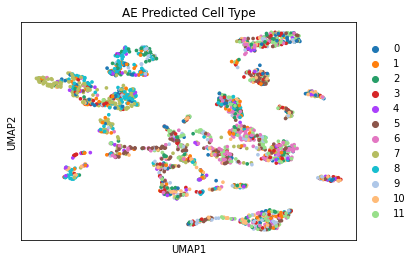

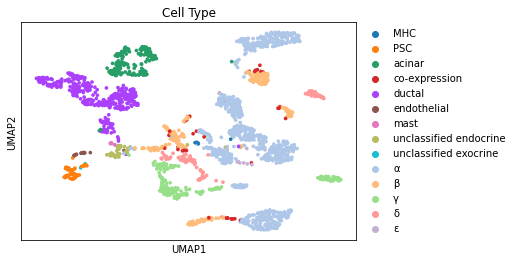

In [216]:
sc.tl.pca(Pancreas_adata, svd_solver='arpack', use_highly_variable=False)
sc.pp.neighbors(Pancreas_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(Pancreas_adata)

sc.pl.umap(Pancreas_adata, color=['AE Predicted Cell Type'])
sc.pl.umap(Pancreas_adata, color=['Cell Type'])

In [217]:
# Read and process GBM data 

GBM_adata = sc.read_text("/content/drive/My Drive/ML for genomics project group /Data/GBM Data/Processed/GBM_LogX.txt", delimiter = '\t', first_column_names=None)
GBM_adata = GBM_adata.T 

# Regress out cell cycle scores
GBMCellCycleScores = pd.read_table("/content/drive/My Drive/ML for genomics project group /Data/GBM Data/Processed/GbmCellCycleScores.txt", delimiter = '\t')
GBM_adata.obs['score_S'] = GBMCellCycleScores['score_S'].values
GBM_adata.obs['score_G2M'] = GBMCellCycleScores['score_G2M'].values
sc.pp.regress_out(GBM_adata, ['score_S', 'score_G2M'])

# Scale (zero-center) data
sc.pp.scale(GBM_adata)

GBM_Metadata = pd.read_csv("/content/drive/My Drive/ML for genomics project group /Data/GBM Data/Processed/metadata2.csv")
GBM_adata.obs['Cell Type'] = GBM_Metadata['cell_assignment'].values

GBMGenes = pd.read_csv("/content/drive/My Drive/ML for genomics project group /Data/GBM Data/Processed/features2.tsv",header=None)
GBMGenelist = []
for item in GBMGenes.values.tolist():
  GBMGenelist.append(item[0])
GBM_adata.var_names = GBMGenelist
GBM_adata.var_names

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2MP1',
       'A4GALT', 'A4GNT', 'AA06',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=23686)

In [218]:
GBMMarkers = MarkerGeneList.iloc[np.asarray(np.where((MarkerGeneList['cell type'] == 'Oligodendrocytes') | 
                                                    (MarkerGeneList['cell type'] == 'T cells') |
                                                    (MarkerGeneList['cell type'] == 'Macrophages')))[0,:],:]

PanglaoDB_GBM = GBMMarkers['official gene symbol']
PanglaoDB_GBM = list(set(PanglaoDB_GBM) & set(GBM_adata.var_names))

# Manually add malignant gene markers 
MalignantGenes = ['CD133','CD44','ABCC3','TNFRSF1A','MGMT','IDH 1','IDH 2','ATRX','1p/19q','TP53','RB','PI3K','RKT','RAS','TERT']
for g in MalignantGenes:
  if ((g in GBM_adata.var_names) & (g not in PanglaoDB_GBM)):
    PanglaoDB_GBM.append(g)

# Create a variable list for input genes / features 
Panglao_GBM_Input = []

for i in range(GBM_adata.shape[1]):
  if GBM_adata.var_names[i] in set(PanglaoDB_GBM):
    Panglao_GBM_Input.append(True)
  else: 
    Panglao_GBM_Input.append(False)

GBM_adata.var['input_features'] = Panglao_GBM_Input

In [219]:
# Create anndata input for the model by filtering GBM_adata
GBM_input = GBM_adata[:,GBM_adata.var['input_features']]
GBM_input

View of AnnData object with n_obs × n_vars = 7930 × 302
    obs: 'score_S', 'score_G2M', 'Cell Type'
    var: 'mean', 'std', 'input_features'

In [220]:
# Creating regularization mask 

# RegLevel = 0

marker_genes = GBM_input.var_names
cell_types = pd.unique(GBMMarkers['cell type'])

marker_gene_cell_type_reg_penalties = np.ones((len(marker_genes), len(cell_types))) * RegLevel
marker_gene_cell_type_reg_penalties.shape

(302, 3)

In [221]:
NumGBMCellTypes = len(GBMMarkers['cell type'].unique())
num_genes = GBM_input.shape[1]
autoencoder = VariationalAutoencoder(NumGBMCellTypes, num_genes, 
                                    marker_gene_cell_type_reg_penalties)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
                    loss=losses.MeanSquaredError())
history = autoencoder.fit(GBM_input.X, GBM_input.X,
                          epochs=25,
                          shuffle=True,
                          validation_data=(GBM_input.X, GBM_input.X))

Epoch 1/25
248/248 [==============================] - 2s 6ms/step - loss: 72.8042 - val_loss: 70.9291
Epoch 2/25
248/248 [==============================] - 1s 5ms/step - loss: 69.1315 - val_loss: 67.3460
Epoch 3/25
248/248 [==============================] - 1s 6ms/step - loss: 65.6329 - val_loss: 63.9301
Epoch 4/25
248/248 [==============================] - 1s 4ms/step - loss: 62.2952 - val_loss: 60.6698
Epoch 5/25
248/248 [==============================] - 1s 6ms/step - loss: 59.1074 - val_loss: 57.5538
Epoch 6/25
248/248 [==============================] - 1s 4ms/step - loss: 56.0599 - val_loss: 54.5738
Epoch 7/25
248/248 [==============================] - 1s 5ms/step - loss: 53.1445 - val_loss: 51.7223
Epoch 8/25
248/248 [==============================] - 1s 4ms/step - loss: 50.3538 - val_loss: 48.9920
Epoch 9/25
248/248 [==============================] - 1s 4ms/step - loss: 47.6814 - val_loss: 46.3772
Epoch 10/25
248/248 [==============================] - 1s 4ms/step - loss: 45.1216

Text(0.5, 0, 'Epochs')

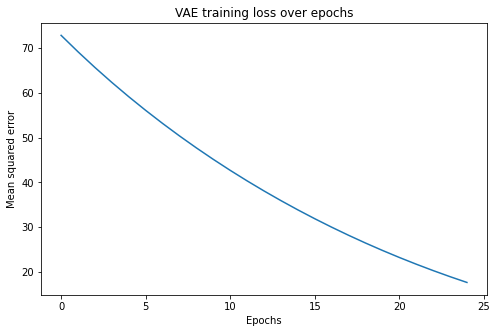

In [222]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.title('VAE training loss over epochs')
plt.ylabel('Mean squared error')
plt.xlabel('Epochs')

In [223]:
latent_embedding, mean, var = autoencoder.embed(GBM_input.X)

cell_type_labels  = []
for item in latent_embedding:
  cell_type_labels.append(str(np.where(item == max(item))[0][0]))

# compute pValue of each assignment and assign 'unknown' labels according p-value threshold
# NumGBMCells = GBM_input.shape[0]
# GBM_Assignment_PValues = []
# pVal_Threshold = 10

# for cell in range(NumGBMCells):
#     MaxIndex = tf.math.argmax(latent_embedding[cell,:]).numpy()
#     pVal = []
#     for LatentNode in range(NumGBMCellTypes):
#       if LatentNode != MaxIndex:
#         pVal.append(Compute_tTest(mean[cell,MaxIndex],var[cell,MaxIndex],
#                                    mean[cell,LatentNode],var[cell,LatentNode],
#                                    num_genes))
#     GBM_Assignment_PValues.append(pVal[np.argmax(pVal)])
#     if pVal[np.argmax(pVal)] > pVal_Threshold:
#       print('Not Confident: ' + cell_type_labels[cell] + ' = ' + str(pVal[np.argmax(pVal)]))
#       cell_type_labels[cell] = 'Unknown'

# GBM_Assignment_PValues = np.array(GBM_Assignment_PValues).ravel()
# GBM_adata.obs['GBM pVal'] = GBM_Assignment_PValues

GBM_adata.obs['VAE Predicted Cell Type'] = cell_type_labels

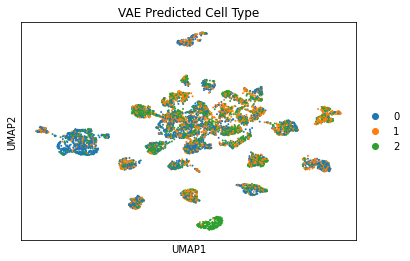

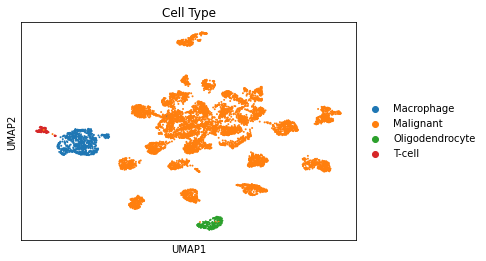

In [224]:
sc.tl.pca(GBM_adata, svd_solver='arpack', use_highly_variable=False)
sc.pp.neighbors(GBM_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(GBM_adata)

sc.pl.umap(GBM_adata, color=['VAE Predicted Cell Type'])
sc.pl.umap(GBM_adata, color=['Cell Type'])

In [225]:
NumGBMCellTypes = len(GBMMarkers['cell type'].unique())
num_genes = GBM_input.shape[1]
autoencoder = Autoencoder(NumGBMCellTypes, num_genes, 
                          marker_gene_cell_type_reg_penalties)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
                    loss=losses.MeanSquaredError())
history = autoencoder.fit(GBM_input.X, GBM_input.X,
                          epochs=25,
                          shuffle=True,
                          validation_data=(GBM_input.X, GBM_input.X))

Epoch 1/25
248/248 [==============================] - 2s 6ms/step - loss: 46.9898 - val_loss: 45.7721
Epoch 2/25
248/248 [==============================] - 1s 5ms/step - loss: 44.6062 - val_loss: 43.4483
Epoch 3/25
248/248 [==============================] - 1s 5ms/step - loss: 42.3383 - val_loss: 41.2355
Epoch 4/25
248/248 [==============================] - 1s 4ms/step - loss: 40.1771 - val_loss: 39.1251
Epoch 5/25
248/248 [==============================] - 1s 5ms/step - loss: 38.1149 - val_loss: 37.1104
Epoch 6/25
248/248 [==============================] - 1s 5ms/step - loss: 36.1451 - val_loss: 35.1852
Epoch 7/25
248/248 [==============================] - 1s 4ms/step - loss: 34.2623 - val_loss: 33.3442
Epoch 8/25
248/248 [==============================] - 1s 4ms/step - loss: 32.4613 - val_loss: 31.5829
Epoch 9/25
248/248 [==============================] - 1s 4ms/step - loss: 30.7379 - val_loss: 29.8971
Epoch 10/25
248/248 [==============================] - 1s 5ms/step - loss: 29.0881

Text(0.5, 0, 'Epochs')

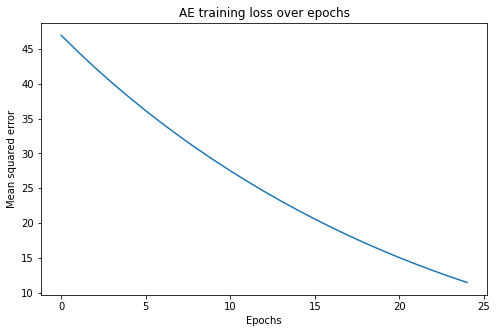

In [226]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.title('AE training loss over epochs')
plt.ylabel('Mean squared error')
plt.xlabel('Epochs')

In [227]:
latent_embedding = autoencoder.embed(GBM_input.X)

cell_type_labels  = []
for item in latent_embedding:
  cell_type_labels.append(str(np.where(item == max(item))[0][0]))

# compute pValue of each assignment and assign 'unknown' labels according p-value threshold
# NumGBMCells = GBM_input.shape[0]
# GBM_Assignment_PValues = []
# pVal_Threshold = 10

# for cell in range(NumGBMCells):
#     MaxIndex = tf.math.argmax(latent_embedding[cell,:]).numpy()
#     pVal = []
#     for LatentNode in range(NumGBMCellTypes):
#       if LatentNode != MaxIndex:
#         pVal.append(Compute_tTest(mean[cell,MaxIndex],var[cell,MaxIndex],
#                                    mean[cell,LatentNode],var[cell,LatentNode],
#                                    num_genes))
#     GBM_Assignment_PValues.append(pVal[np.argmax(pVal)])
#     if pVal[np.argmax(pVal)] > pVal_Threshold:
#       print('Not Confident: ' + cell_type_labels[cell] + ' = ' + str(pVal[np.argmax(pVal)]))
#       cell_type_labels[cell] = 'Unknown'

# GBM_Assignment_PValues = np.array(GBM_Assignment_PValues).ravel()
# GBM_adata.obs['GBM pVal'] = GBM_Assignment_PValues

GBM_adata.obs['AE Predicted Cell Type'] = cell_type_labels

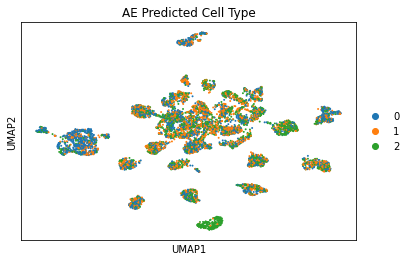

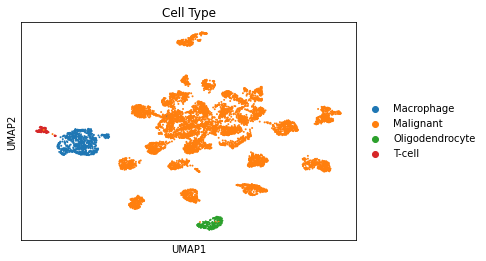

In [228]:
sc.tl.pca(GBM_adata, svd_solver='arpack', use_highly_variable=False)
sc.pp.neighbors(GBM_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(GBM_adata)

sc.pl.umap(GBM_adata, color=['AE Predicted Cell Type'])
sc.pl.umap(GBM_adata, color=['Cell Type'])